## Data Preprocessing (Recap from last lecture)

In [7]:
import warnings
warnings.filterwarnings('ignore')

Importing the dependencies

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,8)

In [9]:
!gdown 1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg

Downloading...
From: https://drive.google.com/uc?id=1-pOuGRd8zuAUKBll-1xkr7_867NwoWHg
To: /content/mobilesales.xlsx
100% 13.7k/13.7k [00:00<00:00, 30.0MB/s]


Here we are just importing the `Mobile Sales` dataset that we have used in the past two lectures. We have performed the three preprocessing steps:

1. Setting the `DATE` feature as index.
2. linear interpolation (to fill the `Nan` values.
3. Taking care of anamolies by clipping the values using quantiles.

Then we have simply visualized the time series.

<Axes: xlabel='DATE'>

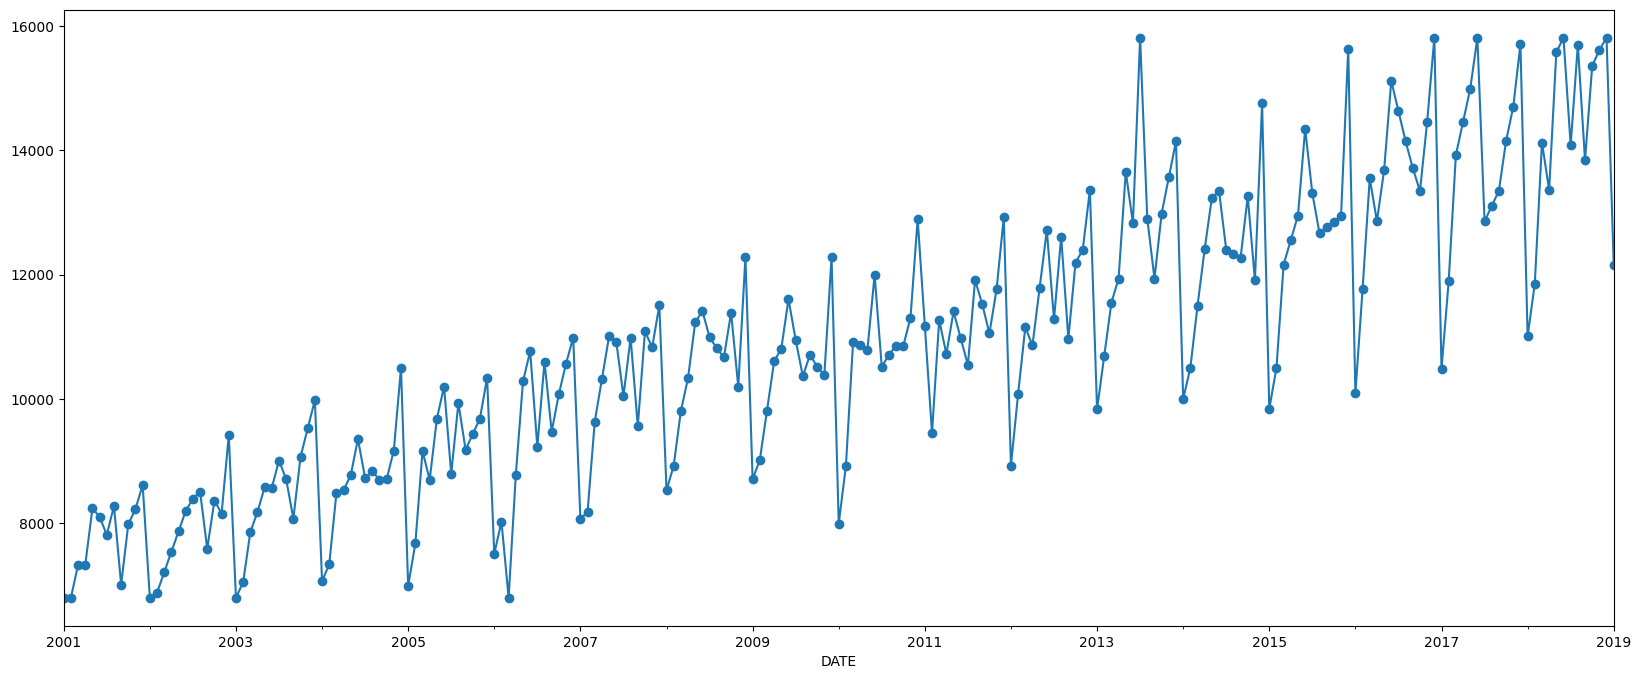

In [10]:
mobile_sales = pd.read_excel('/content/mobilesales.xlsx')
# set index
mobile_sales.set_index('DATE', inplace=True)
# linear interpolation
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')
# anomalies - clip quantiles
mobile_sales.Sales = mobile_sales.Sales.clip(upper=mobile_sales.Sales.quantile(0.98), lower=mobile_sales.Sales.quantile(0.02))
# plot
mobile_sales.Sales.plot(style='-o')

Let's also define the function for calculating all the performance metrics.

In [11]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape

)

# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In the last lecture, the model that gave the best results was **SARIMA Model**

> **Training the SARIMA**

MAE : 536.809
RMSE : 622.984
MAPE: 0.037


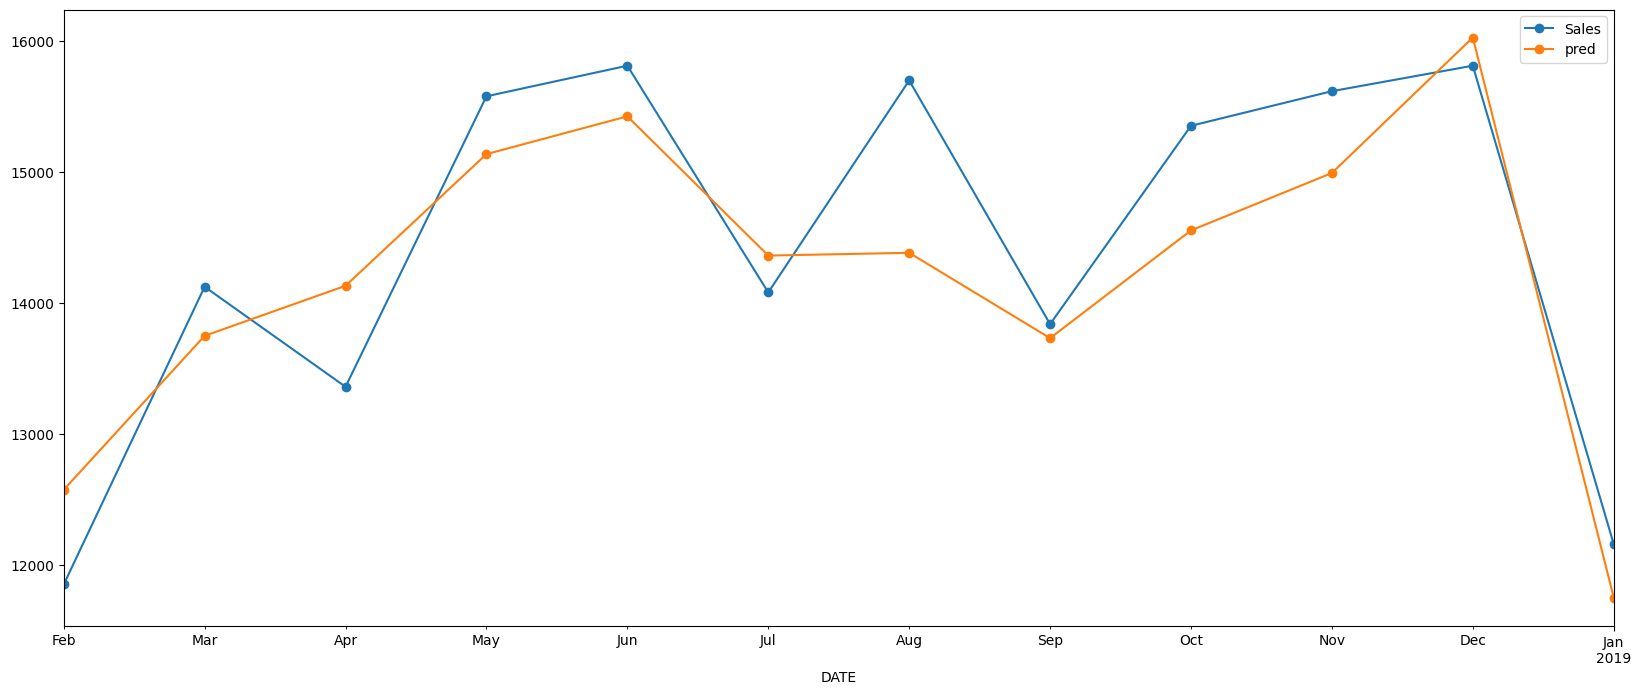

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

train_max_date = mobile_sales.index[-12]
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

model = SARIMAX(train_x.Sales, order=(3, 1, 3), seasonal_order=(1,1,1,12))
model = model.fit(disp=False)
test_x['pred'] = model.forecast(steps=12)
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

There is one more model in the ARIMA family: **SARIMAX** itself!

Before we jump into that, let's cover a few more concepts first, that will help us understand it better.

## Confidence Intervals

Now that we have SARIMA model fitted forecasts, let's look at another functionality of time series models.

- In addition to making predictions, the models can also provide Confidence Intervals.

<br>

#### **Q. What is Confidence Interval?**
Owing to the **potential error** of our forecast, and **unpredictability of future**, we cannot claim to be a hundred percent sure of our forecasts.

But we can still, based on our study of time series, say that the future value, would lie in the **range** of [A,B].

- Naturally A becomes the minimum possible value of our target variable at time t, and
- B becomes the maximum possible value at time t.

- This [A,B] becomes a range for determining the **real possible value** for a certain prediction.

It is called as the **confidence interval.**

It can also be used for performance evaluation.

<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/846/original/Screenshot_2022-08-16_at_11.26.33_AM.png?1660628897" height = '500' width = '800'>

> **Q. Why are Confidence Intervals required?**

For determining the uncertainity of your predictions, after making forecasts.

Confidence Intervals provide an expected range for the real observation. When making decisions, one can utilise the range information better, than just a single point.



####**Q. How to get Confidence Intervals?**
* Different algorithms have different formulations for CI.
* These can be complicated to derive and are out of scope for this lecture.
* We can get the upper and lower values according to the models available in the `statsmodel` library.
* It takes a value of a parameter: **alpha**, which is a measure of how much confidence we want in our forecasts.

One example for 1-step ahead forecast CI is to just take the residual distribution.

For example, the 95% confidence interval will be

$\hat y_{t+1} = \hat y_{t} + u_{resid} ± 2\sigma _{resid}$

Note that for a good forecast $U_{resid}$ should be close to 0


<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/847/original/Screenshot_2022-08-16_at_11.29.38_AM.png?1660629069" height = '500' width = '800'>

####Q. **How to interpret confidence intervals?**

Suppose our forecasted value is $\hat{y}$. And you pass a value of `alpha = 0.05` for which you get the confidence interval as `(m,n)`.

It means that the time series model will estimate the upper(n) and lower(m) bound of values around the forecast, where there is only a 5% chance that the real value will **not be** in that range.

That is, 95% that our forecast will fall within the range `(m,n)`.

Let's use the returned upper and lower bound values of each forecast using the function `conf_int` to create separate series for lower and upper bounds for visualization purpose.

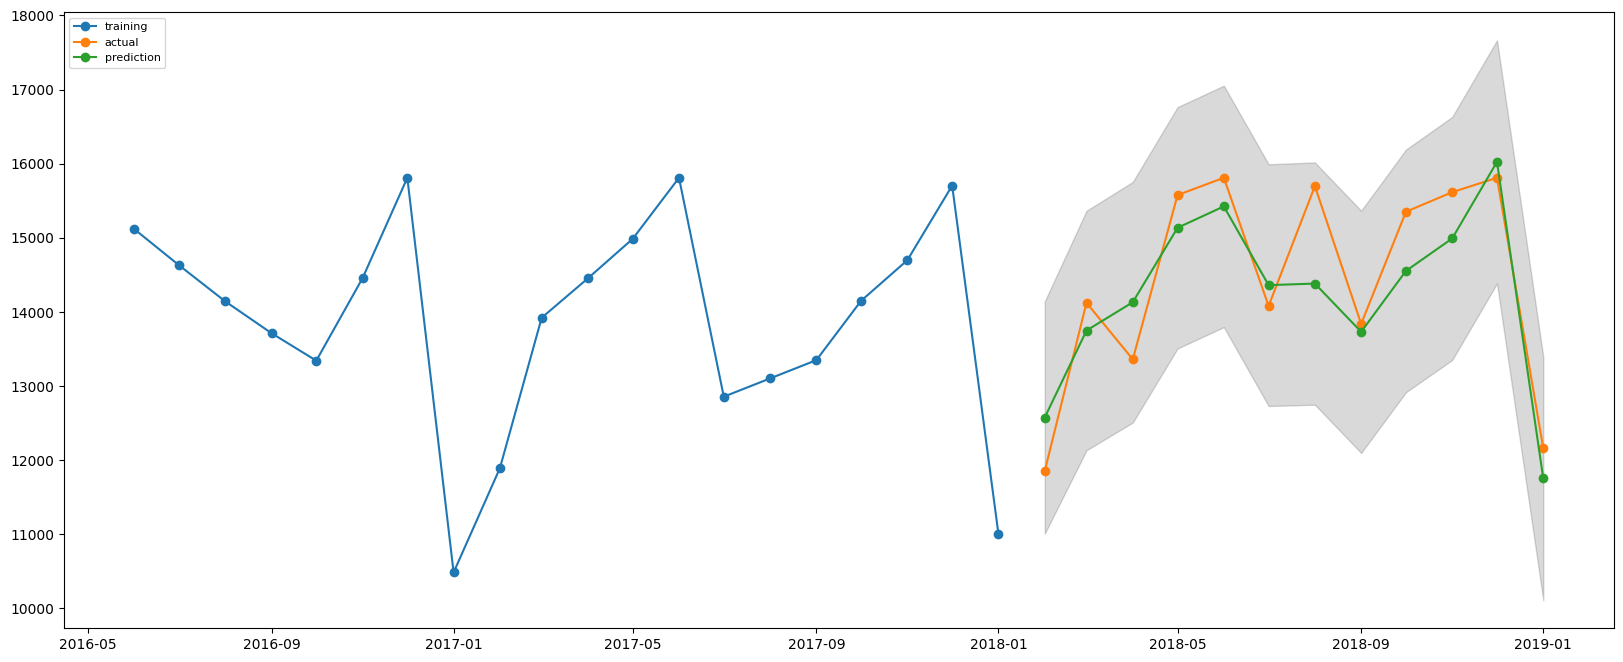

In [13]:
test_x[['lower', 'upper']] = model.get_forecast(steps=12).conf_int(0.05).values
plt.plot(train_x['Sales'][-20:], '-o', label='training')
plt.plot(test_x['Sales'], '-o', label='actual')
plt.plot(test_x['pred'], '-o', label='prediction')
plt.fill_between(test_x.index, test_x['lower'], test_x['upper'],
                 color='k', alpha=.15)
plt.legend(loc='upper left', fontsize=8)
plt.show()

In the above plot, we can observe
- The actual observed values of test set
- Forecasted values of the test set
- Confidence intervals

As shown in the legend of plot, the green and orange lines show the forecasted and actual values respectively.

**Observation**:
- The greyish area around the predictions are actually the values for 95% confidence intervals.
- The actual values are indeed within the predicted confidence intervals

**NOTE:**
>- The visualizations for multiple values of `alpha` can be shown to the learners.
- It will be easier for them to relate that if we decrease the confidence interval the range of values (greyish area) will also be narrower.

> **Q. What does `conf_int` return?**

- In the code we are first getting the forecast for the 1st step just after the last date of fitted training data.
- Then we are using `conf_int` on the forecast, to get the lower and upper bound values for each forecast.

In [16]:
a = model.get_forecast(steps=5).conf_int(0.05).values
a

array([[11007.63031249, 14140.89868022],
       [12133.15706352, 15364.54752641],
       [12507.54593643, 15753.48877695],
       [13506.44549481, 16763.32227672],
       [13794.33721536, 17052.13230073]])

####Quiz-1

```
If the range of values (upper bound - lower bound) gets narrower for the same value of alpha, then:

a. The model has become more confident about its predictions.
b. The model has become lesser confident about its predictions.
c. The model has become more uncertain about its predictions.
```
**answer**: *a*

## Change Points

Consider that we have a time series that looks like the following.

<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/848/original/Screenshot_2022-08-16_at_11.31.52_AM.png?1660629202" height = '500' width = '800'>

<br>

#### **Q. Can the trend line change suddenly?**
One can argue that this series has two possible trend lines, as there are two sub-sections that seem to be heading in different directions.

But recall that in such a case, the **vector sum** of these two trend lines, becomes the new trend line for the entire series.

$ \vec{R} = \vec{T_1} + \vec{T_2} $

The point of intersection of these two trendlines, is called the **changepoint**.

<br>

> **Q. Is the change point useful in forecasting?**

Changepoint is not very useful in forecasting, as we don't know about any change point in the future.

We only know about change points in the past. Better used for analysis

<br>

> **Q. When is the concept of change point useful?**
- As we saw, we can use this concept to obtain a more desirable resultant trend line for our series.
- Also, this concept is useful when we have to explain any decision based on the past value of time series.

#### **Q. How can we detect Change Points?**

There are many methods to detect them, with various human inputs. For getting some intuition, lets discuss a very simple algorithm that uses a **Sliding Window**

* Walk through the series with a window of fixed size
* For each step, compute a **cost** of all elements in the window. There are many options for this cost funtion.
* Wherever the cost locally peaks, the center of the window can be considered as a changepoint.
* We can add other conditions of threshold cost, etc to avaoid making too many detections.

<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/850/original/Screenshot_2022-08-16_at_11.33.50_AM.png?1660629335" height = '500' width = '800'>

In [33]:
from IPython.display import Image
Image(url='https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/752/original/illustration_of_change_point_detectopn_via_sliding-window.gif?1658421673')

<img src = " https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/604/original/image_%281%29.png?1660283183" height = '400' width = '800'>

#### **Q. What are the other factors, based on which one can identify a change point?**

Collage of change points based on different factors
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/406/original/CHANGE_POINT.png?1659598744">


In [34]:
# No need to explain this
def plot_changepoints(signal, changepoints):
  for cp in changepoints:
    plt.axvline(x=cp, color='#FA8072')
  plt.plot(signal, '-*', label='signal')

  start = 0
  trends = np.array([])
  for i in changepoints:
    x = np.arange(start, i)
    y = signal[start:i]
    l1 = np.polyfit(x, y, deg=1)
    trend = x*l1[0] + l1[1]
    trends = np.append(trends, trend)
    start = i

  plt.plot(trends, label='trend')
  plt.legend()
  plt.show()

We will use the **difference in slope for each window**, and wherever the difference is huge, we will mark that as a changepoint.

- For finding the slope of regression line that goes through all points in a window we can use ```numpy.polyfit``` with 1 degree polynomial.
- You can also use ```sklearn.LinearRegression```, but here polyfit syntax is linear.
-Both will give similar results

<br>

>**NOTES**
- Explain the changepoints computations slowly, while plotting at every step

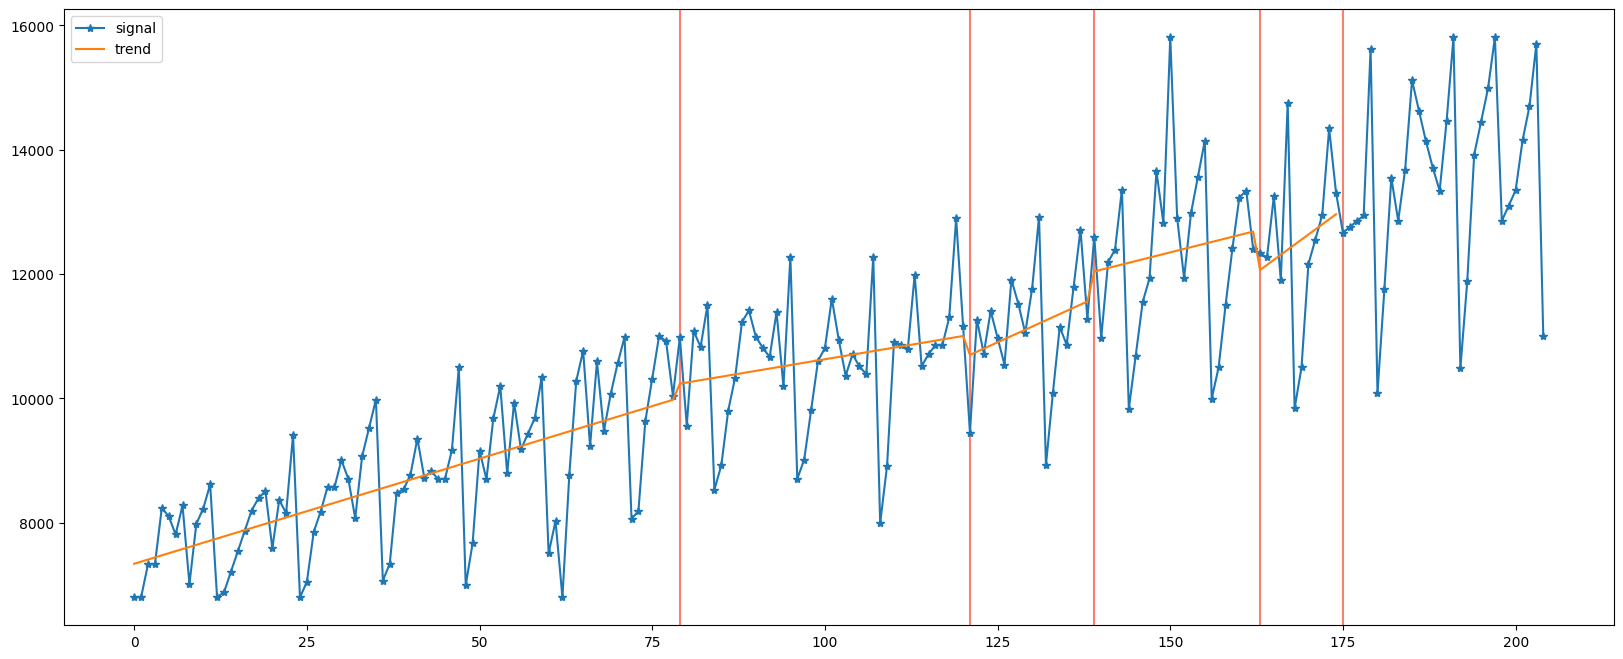

In [18]:
signal = train_x.Sales # Stationarise for mean as cost function
window=60
def get_slope(y):
  return np.polyfit(np.arange(len(y)), y, deg=1)[0]

changepoints = signal.loc[abs(signal.rolling(window, center=True).apply(get_slope).diff()) > 7.5].index
# converting to index from dates
temp = signal.reset_index()
changepoints = temp.loc[temp['DATE'].isin(changepoints)].index.tolist()

plot_changepoints(signal.values, changepoints)

- Great, Looks like we did find some valid changepoints.
- However, maybe depending on the domain we may feel that the cps are too frequent, or close to each other.
- Also we need to experiment with the window and threshold etc.

Let us use a library which has much more complex algorithms to better detect changepoints

Quickly trying the first algorithm from a package called 'rupteres'. If you want to try other on your own, you may visit https://github.com/deepcharles/ruptures

> **NOTES**
> - Just skim through this code, the idea is to just show whats possible, not elaborately cover this library.
- All arguments passed are just first guesses.

In [19]:
!pip install ruptures

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.0 MB/s eta 0:00:00


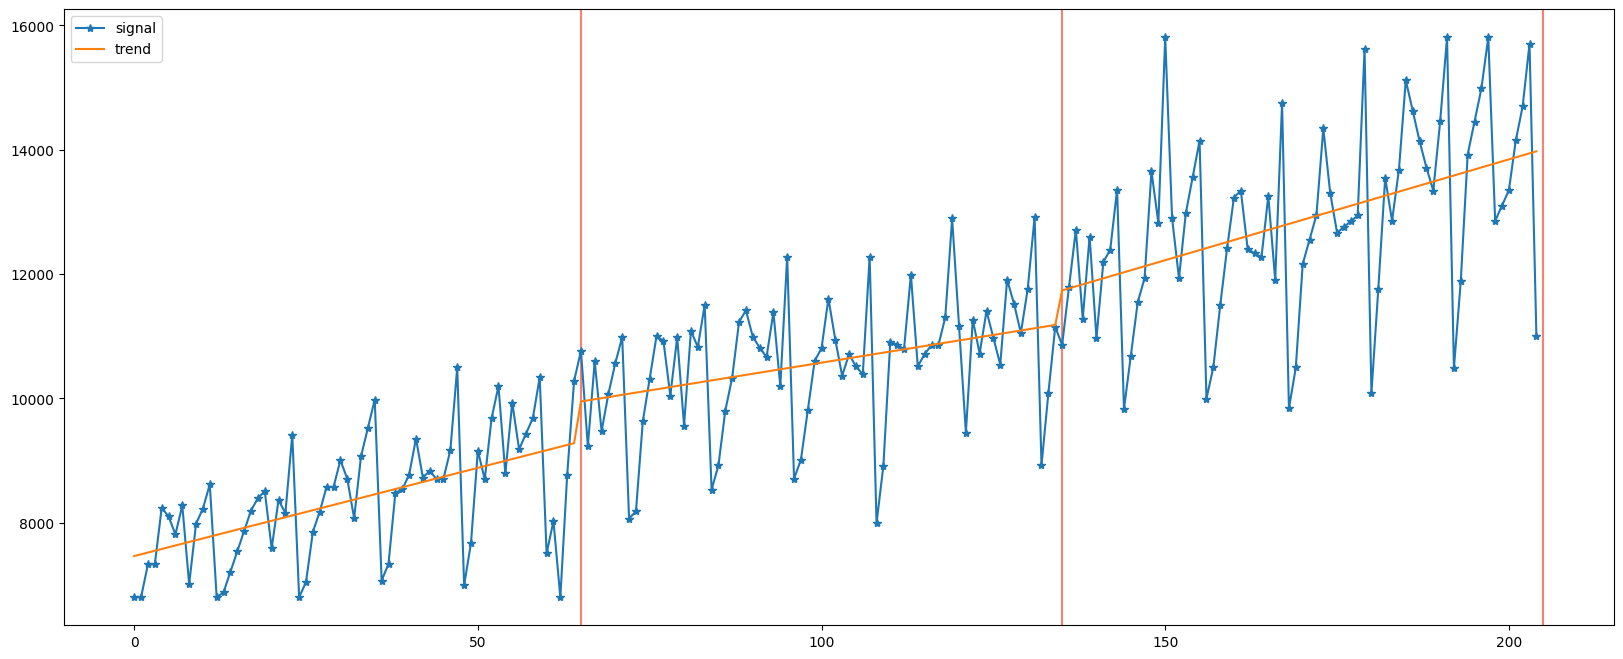

In [20]:
import ruptures as rpt

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 4  # number of breakpoints
signal = train_x.Sales.values
# signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

# detection
algo = rpt.Pelt(model="rbf").fit(signal)
changepoints = algo.predict(pen=5)


plot_changepoints(signal, changepoints)

---


## Imagine you are a Data Scientist at a food chain ‘Xotica’!

Your manager has asked you to forecast the number of visitors for upcoming 39 days (almost 6 weeks) using the number of visitors recorded within the past 1-1.5 years.


Reading the data

In [21]:
!gdown 1Um8gdIjpEx7Iv-VUoBpmGCS80ck_x7AO

Downloading...
From: https://drive.google.com/uc?id=1Um8gdIjpEx7Iv-VUoBpmGCS80ck_x7AO
To: /content/rest_vis.csv
100% 13.1k/13.1k [00:00<00:00, 29.6MB/s]


In [22]:
df = pd.read_csv('/content/rest_vis.csv')
df.head()

,date,weekday,holiday,total
0,1/1/2016,Friday,1,296.0
1,1/2/2016,Saturday,0,191.0
2,1/3/2016,Sunday,0,202.0
3,1/4/2016,Monday,0,105.0
4,1/5/2016,Tuesday,0,98.0


In [23]:
df.shape

(517, 4)


The provided dataset has features `‘Date’, ‘holiday’, 'weekday' and 'total`(total no. of visitors).

The data consists of number of **daily** visitors to the restaurant located in the United States, subject to American holidays.

The data set contains 517 days: 478 days of restaurant's data and 39 days of data which have `Nan` in `total`.

Let's find out the number of rows having values 'Nan' in dataset.

In [24]:
df.isna().sum()

date        0
weekday     0
holiday     0
total      39
dtype: int64

Here let's keep a copy of the original data so that in future, even after modifications on the data we won't have to read the csv again and again.

In [25]:
df1 = df.copy()

Let's drop all the rows which have `Nan`.

In [26]:
df.dropna(inplace = True)

Set the `date` column as index after converting it to datetime format.

In [27]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace = True)
df.head(5)

,weekday,holiday,total
date,,,
2016-01-01,Friday,1,296.0
2016-01-02,Saturday,0,191.0
2016-01-03,Sunday,0,202.0
2016-01-04,Monday,0,105.0
2016-01-05,Tuesday,0,98.0


**NOTE:-**
- Here you can see, that the target variable of the time series is the ```total``` column.
- In our last business case, we saw only date and the target variable.
- However, there are other columns: ```holiday, weekday```.

<br>





#### Plot the source data.

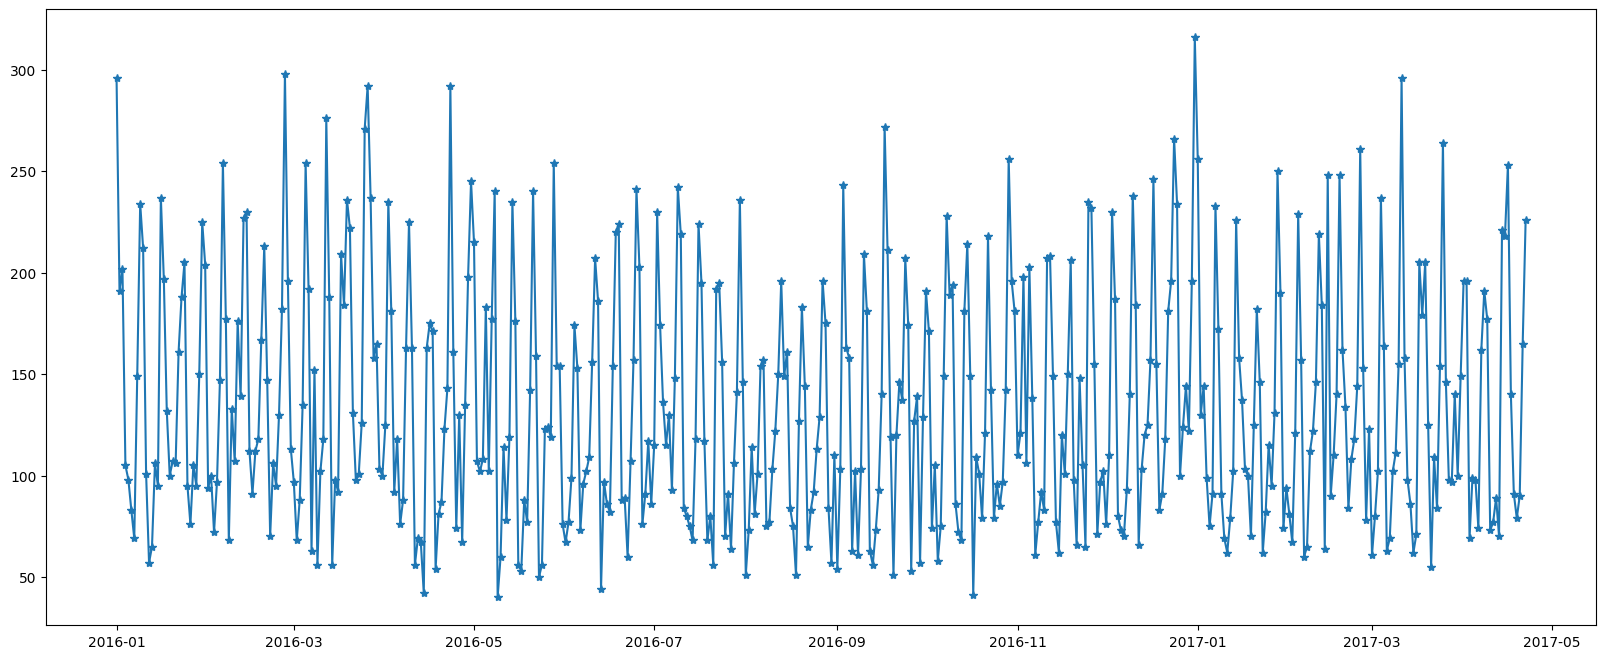

In [28]:
# Lets take a look at our time series plot
plt.plot(df.index, df['total'], '-*')
plt.show()

> **INTERACTION**
> - Can you guess which days of the week can the peaks in the data represent?
> - Ans: weekends

In the above plot, we can see the peaks but we can't map those peaks to any particular days. Therefore let's try to decrease the number of days to plot, so that we get more insights.

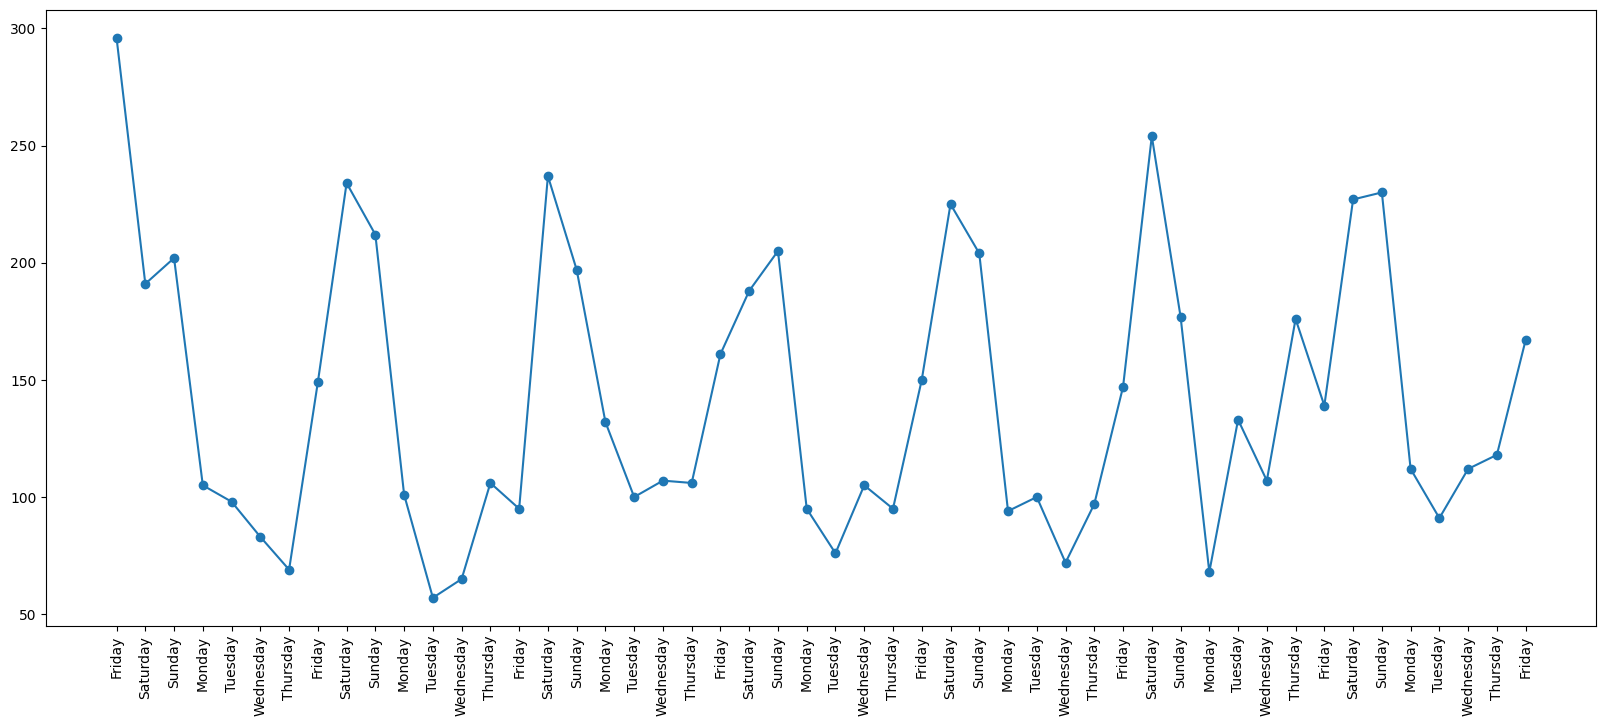

In [29]:
plt.plot(range(50),df['total'][:50], '-o')
plt.xticks(range(0,50), df['weekday'][:50],rotation = 90)
plt.show()

It is easily observable that the peaks in the number of visitors is around Saturday and Sunday.

#### Plot the data with holidays.

We also have the data about `holidays`, therefore let's visualize it to observe any relationship between holidays and number of people visiting if it exists.

In [30]:
df['holiday'].value_counts()

0    446
1     32
Name: holiday, dtype: int64

feature `holiday` is representing whether there is holiday (1) on the day or not(0).

Plot of data with `holiday`. Lets use a red line to indicate that the given day is a holiday.

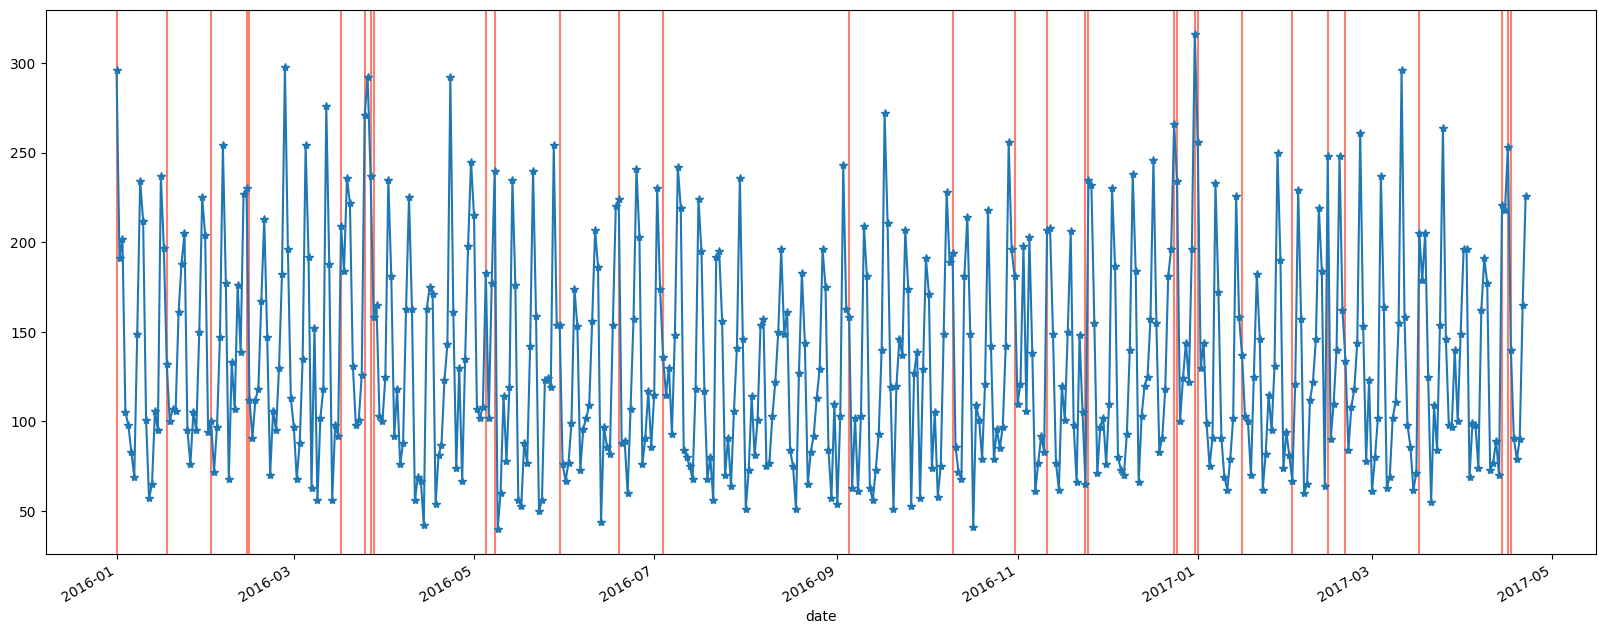

In [31]:
# Lets take a look at our time series plot
holidays = df.loc[df.holiday==1].index
for hday in holidays:
    plt.axvline(x=hday, color='#FA8072')
df.total.plot(style='-*')
plt.show()

**Notice:-**
- We can see that holidays generally see a **peak** in foot falls.

**Now let's try to decompose the time series to see if it follows any pattern**

<Figure size 2000x800 with 0 Axes>

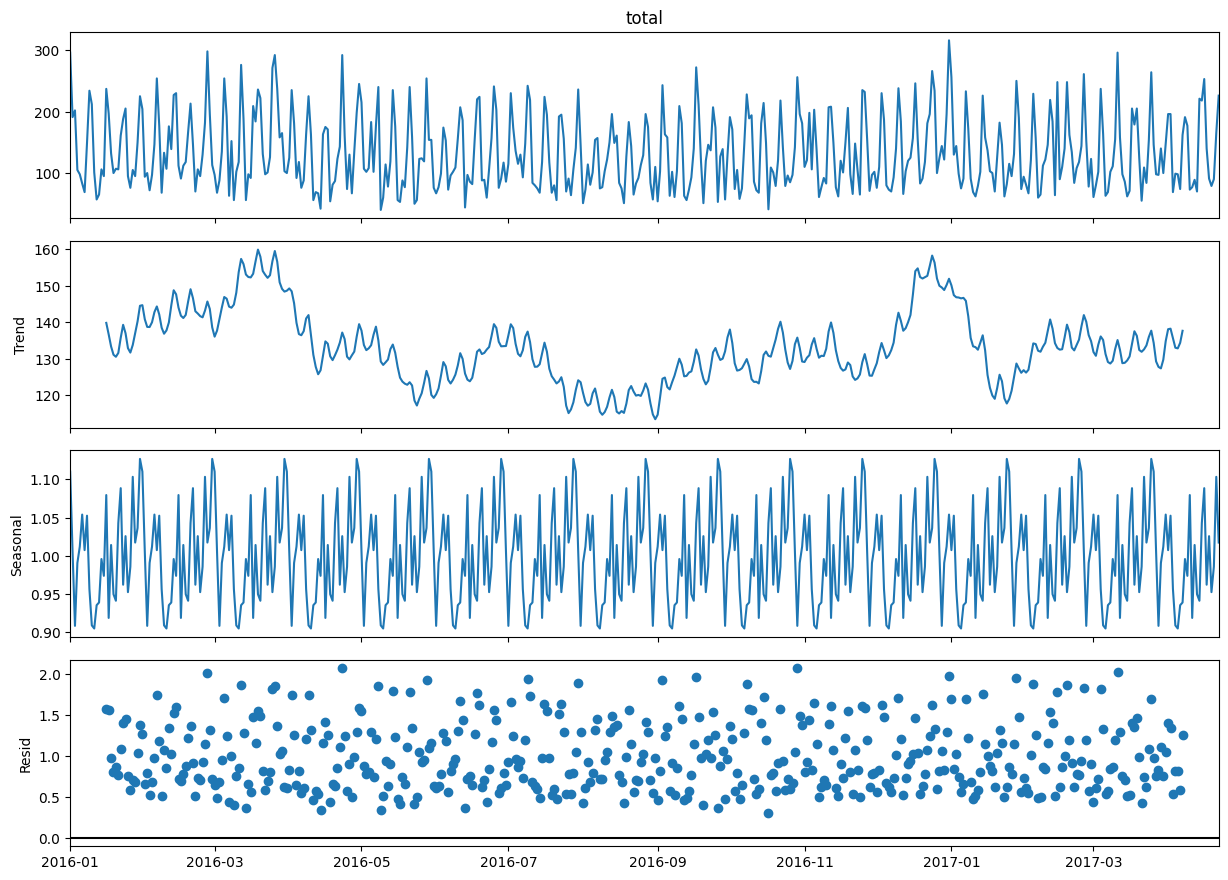

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['total'], model='multiplicative',period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(12, 9)
fig.show()

* From the above decomposition, it's visible that the data consists of seasonality and the trend is increasing and decreasing which is understandable as the number of visitors will increase during the weekends.

* As their is seasonality, let's try to use SARIMA for the predictions.

### Lets generate a baseline forecast

Now we will fit a **SARIMA model** of seasonal order (1,0,1,7) on the training data.

<br>

> **NOTES:-**
- This order is found using `pmdarima` library which we won't be showing here, we are just using the order.
- To find the seasonal order through ACF and PACF plots is quite difficult and it's not very conclusive.
- Therefore it's better to search from a space of multiple hyperparameter values.

Here,
- $P=1$: Seasonal Auto regressive order.
- $D=0$: Differencing order of the seasonal process.
- $Q=1$: Seasonal moving average order.
- $s=7$: periodicity where the pattern repeat itself (length of cycle).
 - We can observe a **weekly** pattern, hence 7
- $p,d,q$: AR order, MA order and the Differencing order respectively, have been kept default (1,0,0)

<br>


> **Though not compulsary, a Few guidelines that one should keep in mind:**
- $m$: seasonality
 - We can identify this from the ACF and PACF plot where our value m is equal to the lag with the greatest autocorrelation coefficient other than that at lag=0.
- $P, Q$: Seasonal AR and MA orders
 - We generally do not want P+Q to exceed 2.
 - Using increasingly complex models will increase the risk of **overfitting**.
- $D$: Seasonal Differencing order
 - This can be found using `Adfuller test` on the seasonal decompose.
 - The rule of thumb for our D parameter is that both `D` and the series differencing order `d` should not be greater than 2.



Let's split the data into train and test.

> **NOTE:-**
- Here picking `436` does not has any objective other than visualization.

In [37]:
train = df.iloc[:436]
test = df.iloc[436:]

In [38]:
test.tail()

,weekday,holiday,total
date,,,
2017-04-18,Tuesday,0,91.0
2017-04-19,Wednesday,0,79.0
2017-04-20,Thursday,0,90.0
2017-04-21,Friday,0,165.0
2017-04-22,Saturday,0,226.0


Let's train a pure seasonality based model, by ignoring the `p, d, q` hyperparamters

In [40]:
model = SARIMAX(train['total'],seasonal_order=(1,0,1,7))
results = model.fit()
fc = results.forecast(42)

Let's analyze the residuals after training the model on the SARIMA

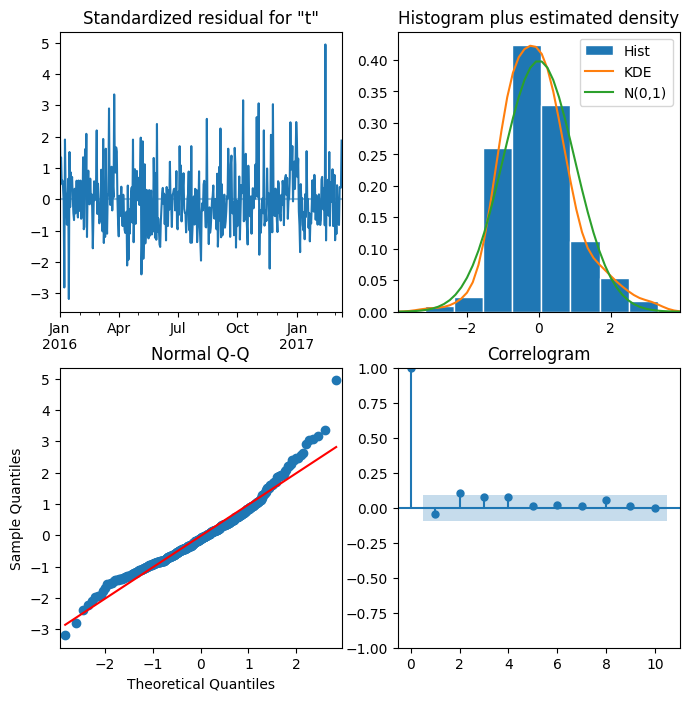

In [41]:
results.plot_diagnostics(figsize=(8,8));

> **Q. By observing the residual plots, what can we infer about the patterns in the residuals?**

- The residuals have **constant variance**.
- Majority of the dots lie on the red line in the Normal Q-Q plot
 - Hence, the residuals follow a **normal distribution.**
- The residuals are **not auto correlated** as there is no significant pattern.


  

#### Some properties of residuals in time series forecasting
 * The residuals should **not be correlated**
  - Correlated residuals will imply that we are unable to capture some information / pattern in our model.
 * It is useful if the residuals are **normally distributed**
  - It makes calculating the prediction intervals easier.
 * The residuals should have a **zero mean**
  - Otherwise, the forecast can said to be biased.
  - Because a positive mean would mean would imply underfitting and vica-versa

---

## Exogenous Variables

Now let's use the predict() function to get the predictions for the observations in the test data.

In [42]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end)

#### Observing the relation of predicted vs actual values on holidays

Let's plot the predicted forecasts and the actual observed values on the test set, and calculate performance scores.

Also, let's add a red line to indicate the **holidays** in the test set.

**Note:**
> - No need to run the cell as the plot will be same as the attached image but arrows will not be there.

MAE : 25.159
RMSE : 31.97
MAPE: 0.202


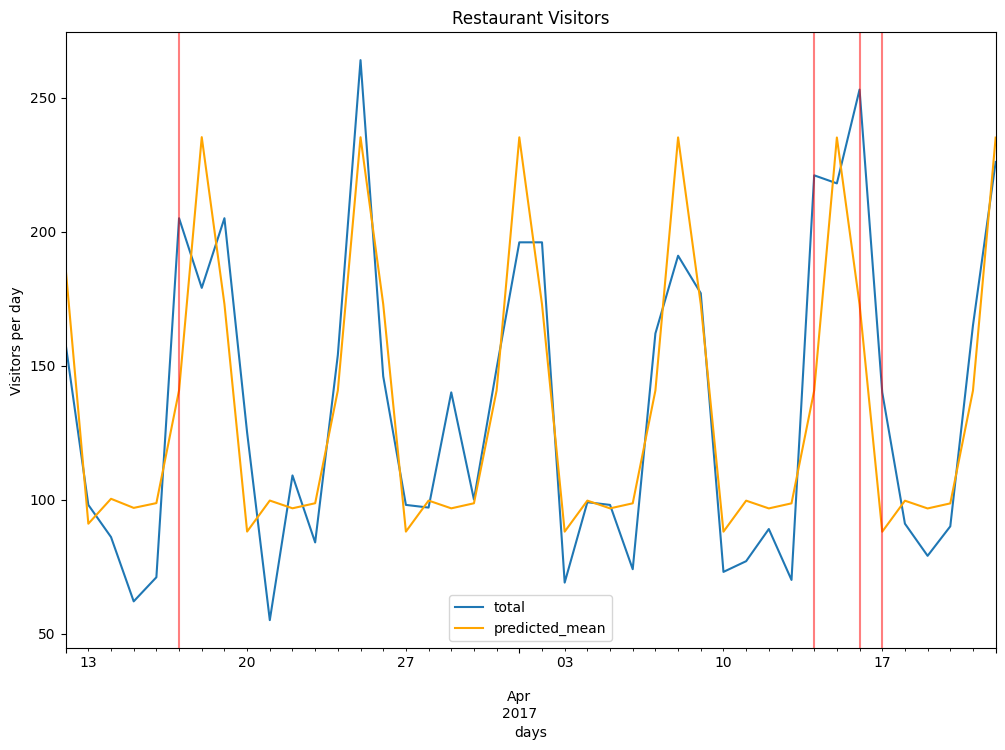

In [44]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'
ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True,color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5)

MAE : 25.159<br>
RMSE : 31.97<br>
MAPE: 0.202<br>
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/768/original/Screenshot_2022-07-22_at_10.41.50_AM.png?1658466294" width="800" height="400">

> **Q. Can you observe any difference between actual and predicted values on the days when there was a holiday?**

 If we look at the plot of total vs predictions, it can be observed that the model has missed peaks for the holidays (see the arrows).

> **Q. What do you think, our predictions missed the peaks on the days of holidays?**

- Right now, we are using **SARIMA model** which is making predictions based on the **past values**.
- However, it does not account for any information about **holiday** or non-holiday dates.

Recall that we have a column `holiday` in our dataset.

`holiday` is an **EXOGENOUS VARIABLE**.

<br>

####**Q. What is exogenous variable?**
Exogenous variables are the input variables that are not influenced by other variables in the system and on which the output variable depends.

This is clearly the case here, because our predictions were lacking on days of holidays.

**Other examples of exogenous variables:-**
- **is New Model Launched**
 - In case of mobile phones, when a new model is launched, it is accompanied by a spike in sales for a few months.
 - Hence, based on the business logic, we might want to put `isNewModelLaunched = 1` for 2 or 3 months after it is launched, to account for the rise in sales.
- **Month of year**
 - Sweater sales would be higher in Nov, Dec, Jan
 - This is a seasonal exogenous variable!
- **Is it raining**
 - Samosa sales in Haldirams would be higher on days that it rains.

![picture](https://drive.google.com/uc?export=view&id=1_BJD3zrtRoozQ_eskiPMlpKIZxQ2j_UZ)



## SARIMAX Model



Naturally, in order to
- incorporate information about holidays and
- improve the performance,

We can utilise the exogenous variable: `holiday` we have in our dataset, and incorporate it in our SARIMA Model.

<br>

This idea of incorporating exogenous variables into SARIMA gave rise to a new model: **SARIMAX Model**

Here, the `X` represents exogenous variable

<br>

> **Q. What is SARIMAX Model?**

The only difference between SARIMA and SARIMAX is that here, we can incorporate exogenous variable into the calculations of our forecasts.

- Even here, we have 7 hyperparameters: `p, d, q, P, D, Q, s`

- Additionally, we need to specify the exogenous variables to be used in the `exog` parameter of SARIMAX function

<br>

> **Q.  How is the exogenous variable incorporated?**

Exogenous variables are assigned a weight, say $w_i$,
- We dont need to initialise this, it is learned and trained by SARIMAX, and taken care of under the hood.

This is done in addition to the SARIMAX operations.

![picture](https://drive.google.com/uc?export=view&id=1uejb57qArRxKiD10mRmRVVhb8R6YGxrQ)


Now let's fit a SARIMAX model with the exogenous variable 'holiday'.

In [45]:
model = SARIMAX(train['total'],exog=train['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()

In the above code snippet we are fitting a SARIMAX model with exogenous variable `holiday`

<br>

#### Mathematical intuition of SARIMAX
- SARIMAX model takes exogenous variables into account
 - i.e. variables measured at time $t$ that influences the value of our time series at time $t$, but that are not autoregressed on.
- To do this, we simply add the terms in on the right hand side of our ARIMA and SARIMA equations.

<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/008/851/original/Screenshot_2022-08-16_at_11.35.51_AM.png?1660629482" height = '400' width = '700'>

Let's obtain the forecasts with this SARIMAX model trained with exogenous variable.

In [46]:
exog_forecast = test[['holiday']]  # requires two brackets to yield a shape of (35,1)
predictions = results.predict(start=start, end=end, exog=exog_forecast).rename('Predictions')

#### Let's plot the predicted vs actual forecast values, and observe them closely on holidays.

**Note:**
> * No need to run the cell as the plot will be the same but arrows will not be there.

MAE : 18.649
RMSE : 22.93
MAPE: 0.161


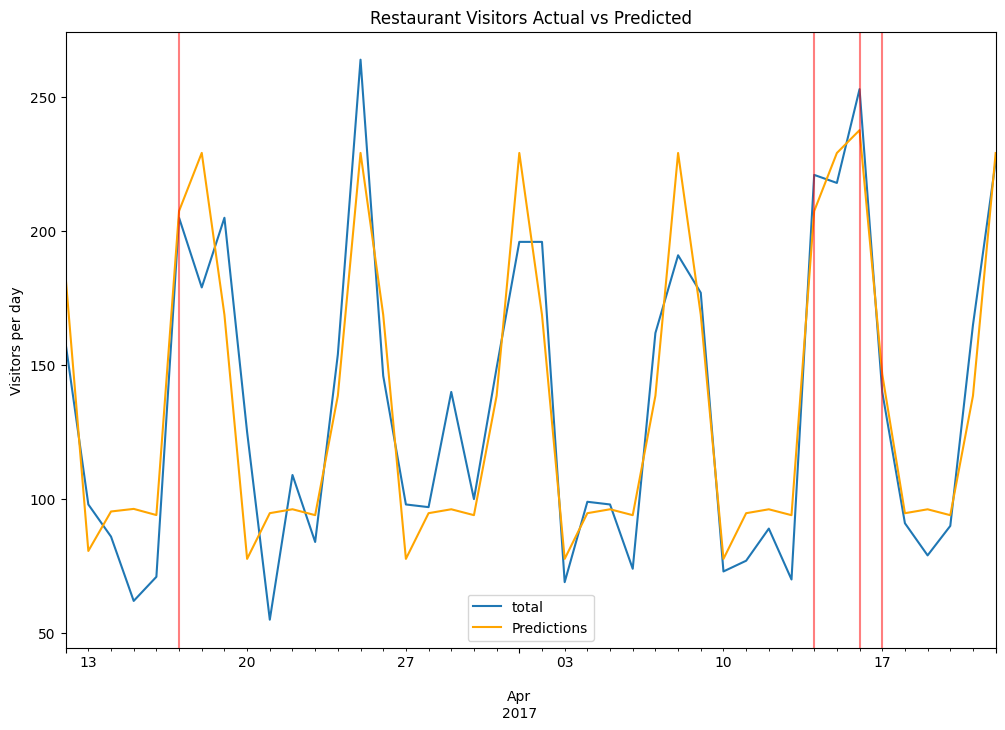

In [47]:
performance(test['total'], predictions)
# Plot predictions against known values
title='Restaurant Visitors Actual vs Predicted'
ylabel='Visitors per day'
xlabel=''

ax = test['total'].plot(legend=True,figsize=(12,8),title=title)
predictions.plot(legend=True, color = 'orange')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in test.query('holiday==1').index:
    ax.axvline(x=x, color='red', alpha = 0.5);

MAE : 18.649<br>
RMSE : 22.93<br>
MAPE: 0.161<br>
<img src = "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/007/810/original/Screenshot_2022-07-22_at_9.12.57_PM.png?1658504130" width = 800, height = 400/>

- It can be observed that the predictions now are somewhat more closer to the peaks, for holidays.
 - Observe the arrows.

- Moreover, the peformace has also improved a lot.



####**Forecasting for the 39 newer observations**

We earlier dropped the rows which had Nan in the starting, now let's predict the values of `total` for these 39 observations.

Now we will be using SARIMAX to forecast the number of visitors of the last 39 observations which had null values. We will be using the 'holiday' data.

In [48]:
model = SARIMAX(df['total'],exog=df['holiday'],order=(1,0,0),seasonal_order=(1,0,1,7),enforce_invertibility=False)
results = model.fit()
exog_forecast = df1[478:][['holiday']]
fcast = results.predict(478,df1.shape[0]-1,exog = exog_forecast).rename('Forecast')

In the above code snippet we are using `df1` to get the `holiday` data for the rows where the `total` was none and we dropped them.

Here we are just visualizing the last 100 observations of the dataset, for clear visualization.

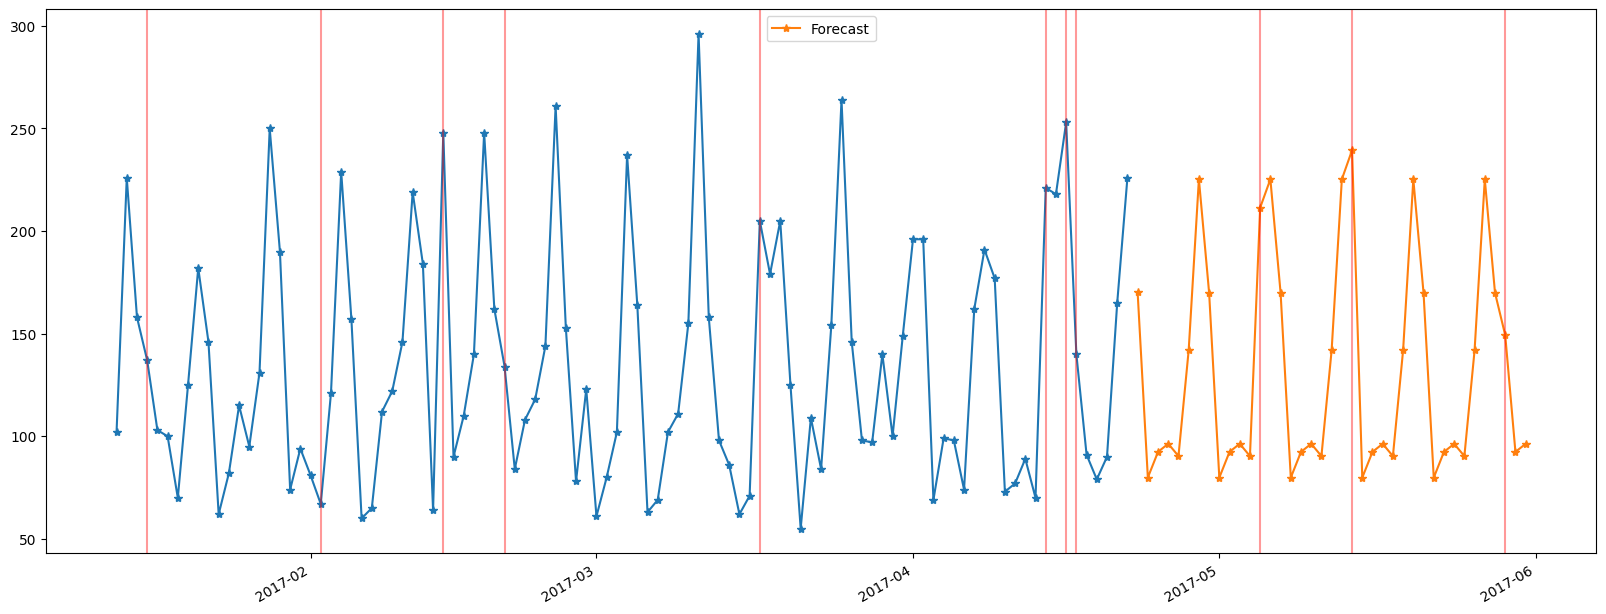

In [49]:
# Plot the forecast alongside historical values
title='Restaurant Visitors'
ylabel='Visitors per day'
xlabel='days'

# ax = df['total'][-100:].plot(legend=True,figsize=(16,5),title=title, style = '-*')
plt.plot(df[-100:].index, df[-100:].total, '-*')
fcast.plot(legend=True, style = '-*')
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in df[-100:].query('holiday==1').index:
    plt.axvline(x=x, color='red', alpha = 0.4)

for x in df1[-42:].query('holiday==1').date:
    plt.axvline(x=pd.to_datetime(x), color='red', alpha = 0.4)


Note that as a real forecaster,
- you will have to decide wether the future plot looks correct or not.
- Metrics and other measures aside, it is your responsibility that forecast should be correct.
- Hence forecasting is a game of experience, not just theory and code

####Quiz-2

```
You are modeling a time series model to predict the production of corn. Which of the following can not be an
exogenous variable.
a. weather
b. date
c. fertilizer
d. crop eating pests
```

**Answer**: b